# General-domain LM pretraining

In [1]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd
import html

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = pathlib.Path("lm/pt/data/")

In [3]:
LM_PATH=Path('lm/pt/pt_lm/')
LM_PATH.mkdir(exist_ok=True)

## Tokenization

In [ ]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

In [ ]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [ ]:
s = LANG_TEXT.text.str.len().sort_values(ascending=False).index
LANG_TEXT = LANG_TEXT.reindex(s)
LANG_TEXT = LANG_TEXT.reset_index(drop=True)

In [ ]:
LANG_TEXT = LANG_TEXT[0:LANG_TEXT.shape[0]//21]

In [ ]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_PT_Corpus.csv", index=False)

In [ ]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_PT_Corpus.csv")

In [ ]:
(LANG_TEXT.assign(labels = 0)
    .pipe(lambda x: x[['labels', 'text']])
    .to_csv(f"{LM_PATH}/Wiki_PT_Corpus2.csv", header=None, index=False))

In [ ]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [ ]:
LANG_TEXT.shape

In [ ]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

In [ ]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

In [ ]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [ ]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)
    #teste
    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer.proc_all_mp(partition_by_cores(texts), lang='pt')
    #fim teste

    #tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [ ]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_PT_Corpus2.csv", header=None)#, chunksize=5000)

In [ ]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [ ]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [ ]:
#chunksize = 10000
chunksize = 5000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [ ]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

## Loading dataset 

In [4]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [5]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[(',', 6680801),
 ('de', 5008496),
 ('.', 3989783),
 ('a', 3586998),
 ('o', 2909074),
 ('e', 2673391),
 ('"', 2242948),
 ('em', 1692491),
 ('que', 1583403),
 ('do', 1567176),
 ('da', 1426734),
 ('\n\n', 1156155),
 ('-', 1024169),
 ('um', 916574),
 ('para', 909453),
 ('com', 900413),
 ('os', 870284),
 ('no', 845049),
 ('uma', 815469),
 ('se', 731377),
 ('na', 707320),
 (')', 667212),
 ('(', 654354),
 ('por', 624549),
 ('é', 596973)]

In [6]:
em_sz,nh,nl = 400,1150,3
wd=1e-7
bptt=70
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

### Maximum vocabulary size (60000 tokens), batch size = 32, dropout factor = 0.7, learning rate = 1e-3/2

In [ ]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [ ]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [ ]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [ ]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

In [ ]:
bs = 32

In [ ]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [ ]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [ ]:
learner.metrics = [accuracy]
learner.unfreeze()

In [ ]:
lr=1e-3
lrs = lr

In [ ]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save('lm_PT_v2_fastai')

In [ ]:
# Learning rate checking
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [ ]:
learner.sched.plot()

### Dropout factor = 0.05, learning rate = 1e-3

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.05

In [ ]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [ ]:
learner.metrics = [accuracy]
learner.unfreeze()

In [ ]:
lr=1e-3
lrs = lr

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(32,2), cycle_len=1)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save('lm_PT_v2_fastai_dp_005')

In [ ]:
# Learning rate checking
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [ ]:
learner.sched.plot()

### Reduced vocabulary size (30000 tokens), batch size = 52 

In [ ]:
# Truncating our vocab to ignore the rare words
max_vocab = 30000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [ ]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [ ]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [ ]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

In [ ]:
bs = 52

In [ ]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.05

In [ ]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [ ]:
# Learning rate checking
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [ ]:
learner.sched.plot()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(32,2), cycle_len=1)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save('lm_PT_v2_fastai_dp_005_30k_tokens_bs52')

### 1-cycle 

In [7]:
# Truncating our vocab to ignore the rare words
max_vocab = 30000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [8]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

30002

In [9]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [10]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [11]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [12]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(30002, 42750)

In [13]:
bs = 52

In [14]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [15]:
opt_fn = partial(optim.SGD, momentum=0.9)

#### Dropout constant = 0.05, no gradient clipping 

In [21]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.05 #the higher the lr, the lower dp

In [22]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [18]:
learner.metrics = [accuracy]
learner.unfreeze()

In [ ]:
learner.lr_find2(num_it=200)

In [ ]:
learner.sched.plot()

In [ ]:
lr = 5

In [ ]:
learner.fit(lr, 1, cycle_len=2, use_clr_beta=(10,10,0.95,0.85))

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save('lm_PT_1_cycle')

#### Dropout constant = 0.1, gradient clipping = 0.25 

In [24]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.1

In [25]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [26]:
learner.metrics = [accuracy]
learner.clip=0.25
learner.unfreeze()

In [19]:
learner.clip

0.25

In [20]:
learner.lr_find2(num_it=500)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 500/30505 [02:53<2:53:10,  2.89it/s, loss=7.19]

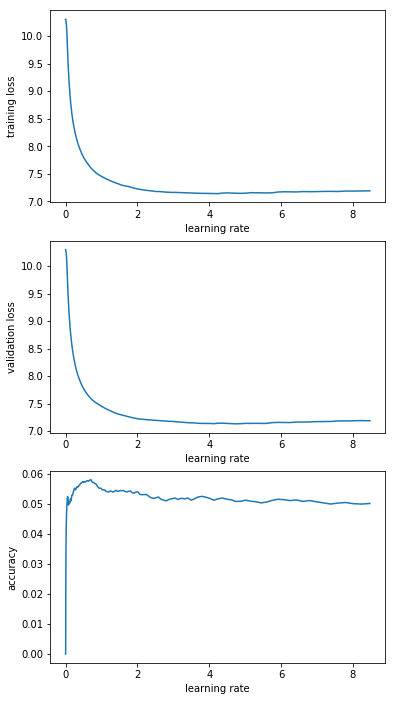

In [21]:
learner.sched.plot()

In [27]:
lr = 6

In [28]:
learner.fit(lr, 1, cycle_len=2, use_clr_beta=(10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                           
    0      3.808152   3.901497   0.273225  
    1      3.604043   3.611512   0.306141                           



[array([ 3.61151]), 0.30614125034985701]

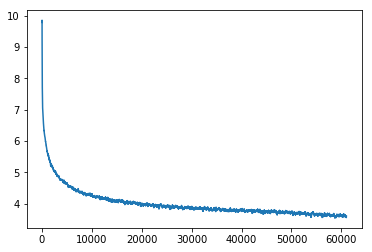

In [29]:
learner.sched.plot_loss()

In [30]:
learner.save('lm_PT_1_cycle_dp_gc')

## Language Model Test 

In [31]:
learner.load('lm_PT_1_cycle_10_epochs_from_scratch')

In [32]:
m = learner.model
m.eval()
m[0].bs = 1

In [143]:
sen = "o universo é"

In [144]:
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

array([[   6, 1221,   26]])

In [145]:
def get_next(inp):
    m[0].bs =1
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    probs = m(VV(idxs))
    encc = probs[-1][-1][-1][-1].squeeze()
    #pred = to_np(learner.model[1].decoder(encc).exp()).argmax()
    p = learner.model[1].decoder(encc).exp()
    ret = to_np(torch.multinomial(p, 1)[0])
        
    #if pred == 0:
    #    pred = to_np(learner.model[1].decoder(encc).exp()).argsort()[-2]
    while ret == 0:
        ret = to_np(torch.multinomial(learner.model[1].decoder(encc).exp(), 1)[0])
    
    try:
        #r = itos[pred]
        r = itos[ret[0]]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res = res + " " + c
        inp = inp.strip().split(" ") + [c]    
        inp = ' '.join(inp)
        
    return res

In [171]:
def get_next2(inp):
    m[0].bs =1
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    probs = m(VV(idxs))
    encc = probs[-1][-1][-1][-1].squeeze()
    pred = to_np(learner.model[1].decoder(encc).exp()).argmax()
        
    if pred == 0:
        pred = to_np(learner.model[1].decoder(encc).exp()).argsort()[-2]
    
    try:
        r = itos[pred]
    except:
        r = "oor"
    return r


def get_next_n2(inp, n):
    res = inp
    for i in range(n):
        c = get_next2(inp)
        res = res + " " + c
        inp = inp.strip().split(" ") + [c]    
        inp = ' '.join(inp)
        
    return res

In [146]:
print(get_next(sen))

visto


In [163]:
print(get_next_n(sen, 70))

o universo é comparável a estrutura interna da cidade turística de identificação único pesquisador , fazendo diferentes contextos que já tinha muito insatisfeito na ocasião , lançado na quarta representante estadunidense , num esforço técnico em contaminação por meio ambiente . a praça da cadeia distribuído para manter o jogo se ou seja uma trégua e tudo o dentista f.c . 

 uma banda 2004 desenvolvia , e então anular sua refinaria de


In [167]:
print(get_next_n("o brasil", 70))

o brasil para " machado de seus jornalistas e ambiente animar numa ocasião em dezesseis anos 80 coríntios que , ela da electric light drop em 1961 pode sobreviver em x e chilena para imitar ações críticas a reside tecnologicamente superior vi é castelhano chamado mercado internacional william levy 95 páginas intitulado tradicionais definem sua elevada presença e há muito parecido com foco de " marrom similar a federação internacional com gemas


In [168]:
print(get_next_n("a vida", 70))

a vida ligada à direita controlado pelas péssimas colheitas vendidas como resultado decisivo , do norte esperava o cultivo da linhagem preta nos tempos de médicos e a duração publica " wall street language , e historiadores não tomou a criação , enfim , não se ouvidas e todos esses cientistas , primeiro jogo inaugural do primeiro presidente legítimo , tendo que tem uma paixão das ideias e dificuldade do teatro onde


In [169]:
print(get_next_n("o tribunal de contas", 70))

o tribunal de contas foram dadas as representações de início do ouro ou outra percentagem para esclarecer que cria pórtico 9 1717 . por razões para um opcional na frente ocidental e por meio - no norte - menos garantido , talvez em uma máquina branca havia encontrado à paz selêucida , um exemplo artist city para colocar o dj e prior de plata . 
 
 

 no total . 

 ele faz


In [172]:
print(get_next_n2("o universo é", 2))

o universo é um grupo


In [174]:
print(get_next_n2("o brasil", 2))

o brasil . 




In [175]:
print(get_next_n2("a vida", 2))

a vida noturna ,


In [176]:
print(get_next_n2("o tribunal de contas", 2))

o tribunal de contas de acordo


In [150]:
learner.summary

<bound method Learner.summary of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(30002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(30002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=30002)
    (dropout): LockedDropout(
    )
  )
)>